In [1]:
import torch
print(torch.cuda.is_available())

True


In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch
import torch.nn as nn
import torch.nn.functional as F
import nltk
from nltk.corpus import stopwords 
from collections import Counter
import string
import re
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

# nltk.download('stopwords')

In [3]:
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU is available


In [4]:
# Read the IMDB Reviews (.csv) file
df = pd.read_csv("base.csv")
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


### Splitting to train and test data
We will split data to train and test initially. Doing this on earlier stage allows to avoid data lekage.

In [5]:
X, y = df['review'].values, df['sentiment'].values
x_train, x_test, y_train, y_test = train_test_split(X, y, stratify=y)
print(f'shape of train data is {x_train.shape}')
print(f'shape of test data is {x_test.shape}')


shape of train data is (37500,)
shape of test data is (12500,)


### Analysing sentiment

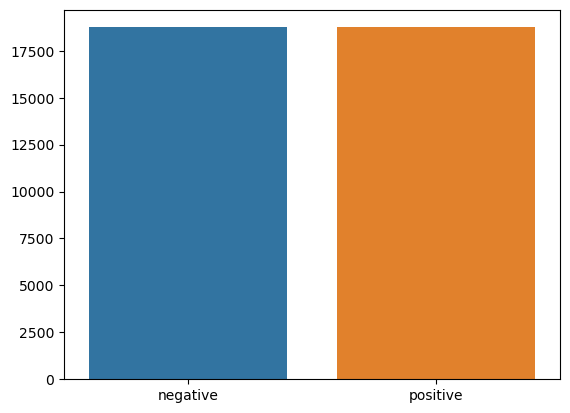

In [6]:
dd = pd.Series(y_train).value_counts()
sns.barplot(x=np.array(['negative','positive']),y=dd.values)
plt.show()

### Tokenisation

In [7]:
def preprocess_string(s):
    # Remove all non-word characters (everything except numbers and letters)
    s = re.sub(r"[^\w\s]", '', s)
    # Replace all runs of whitespaces with no space
    s = re.sub(r"\s+", '', s)
    # replace digits with no space
    s = re.sub(r"\d", '', s)

    return s

def tokenize(x_train, y_train, x_val, y_val):
    word_list = []
    
    # stopwords: Words that have little to no significance in NLP tasks due to their high freuency and lack of semantic meaning
    stop_words = set(stopwords.words('english')) 
    
    # Iterate through each sentence in x_train
    for sent in x_train:
        # Split sentence into words and preprocess each word
        for word in sent.lower().split():
            word = preprocess_string(word)  # Assuming preprocess_string is defined elsewhere
            # Check if word is not a stop word and is not empty after preprocessing
            if word not in stop_words and word != '':
                word_list.append(word)
  
    # Count occurrences of each word
    corpus = Counter(word_list)
    # Sort words based on frequency and select top 1000 most common words
    corpus_ = sorted(corpus, key=corpus.get, reverse=True)[:1000]
    # Create a dictionary mapping each word to a unique integer (1-indexed)
    onehot_dict = {w: i+1 for i, w in enumerate(corpus_)}
    
    # Tokenize x_train and x_val based on onehot_dict
    final_list_train = [[onehot_dict.get(preprocess_string(word), 0) for word in sent.lower().split() 
                         if preprocess_string(word) in onehot_dict.keys()] for sent in x_train]
    
    final_list_test = [[onehot_dict.get(preprocess_string(word), 0) for word in sent.lower().split() 
                        if preprocess_string(word) in onehot_dict.keys()] for sent in x_val]
    
    # Encode labels ('positive' as 1 and 'negative' as 0)
    encoded_train = np.array([1 if label == 'positive' else 0 for label in y_train])
    encoded_test = np.array([1 if label == 'positive' else 0 for label in y_val])
    
    # Return tokenized data, encoded labels, and the vocabulary dictionary
    return final_list_train, encoded_train, final_list_test, encoded_test, onehot_dict

In [8]:
# Assume tokenize function tokenizes the input data and builds a vocabulary

# Assuming x_train, y_train, x_test, y_test are lists or arrays containing training and testing data
# and vocab is a dictionary that maps words to indices

# Tokenize the training and testing data and build vocabulary
x_train, y_train, x_test, y_test, vocab = tokenize(x_train, y_train, x_test, y_test)

In [9]:
print(f'Length of vocabulary is {len(vocab)}')

Length of vocabulary is 1000


### Analysing review length

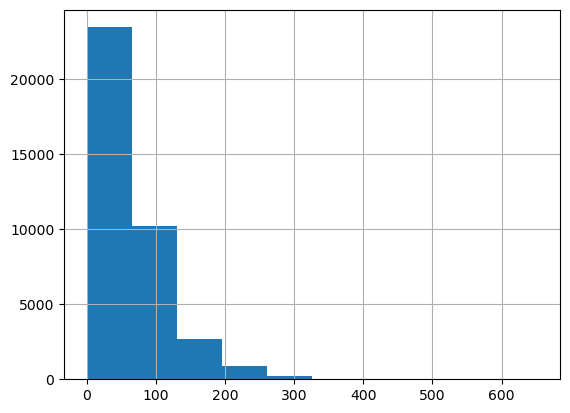

count    37500.000000
mean        69.439627
std         48.456365
min          0.000000
25%         39.000000
50%         54.000000
75%         85.000000
max        652.000000
dtype: float64

In [10]:
rev_len = [len(i) for i in x_train]
pd.Series(rev_len).hist()
plt.show()
pd.Series(rev_len).describe()

### Padding
Now we pad each of the sequences to their maximum length

In [11]:
def padding_(sentences, seq_len):
    # Initialize a NumPy array filled with zeros to store the padded sequences
    features = np.zeros((len(sentences), seq_len), dtype=int)

    # Iterate over each sequence (or sentence) in the input list 'sentences'
    for ii, review in enumerate(sentences):
        # Check if the current sequence 'review' is not empty
        if len(review) != 0:
            features[ii, -len(review):] = np.array(review)[:seq_len]

    # Return the NumPy array 'features' containing the padded or truncated sequences
    return features

In [12]:
#we have very less number of reviews with length > 500.
#So we will consideronly those below it.
x_train_pad = padding_(x_train,500)
x_test_pad = padding_(x_test,500)

print(len(x_test), len(y_test))

12500 12500


In [13]:
# Convert training and testing data to numpy array
x_train_pad = np.array(x_train_pad)
x_test_pad = np.array(x_test_pad)
y_train = np.array(y_train)
y_test = np.array(y_test)

In [14]:
# create Tensor datasets
train_data = TensorDataset(torch.from_numpy(x_train_pad), torch.from_numpy(y_train))
valid_data = TensorDataset(torch.from_numpy(x_test_pad), torch.from_numpy(y_test))

# dataloaders
batch_size = 50

# make sure to SHUFFLE your data
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=batch_size)

In [15]:
# obtain one batch of training data
dataiter = iter(train_loader)
sample_x, sample_y = next(dataiter)

print('Sample input size: ', sample_x.size()) # batch_size, seq_length
print('Sample input: \n', sample_x)
print('Sample input: \n', sample_y)

Sample input size:  torch.Size([50, 500])
Sample input: 
 tensor([[  0,   0,   0,  ..., 219,  12,   1],
        [  0,   0,   0,  ..., 508,  28,  83],
        [  0,   0,   0,  ...,   1, 669,   2],
        ...,
        [  0,   0,   0,  ..., 780,  10, 890],
        [  0,   0,   0,  ...,  46, 211,   2],
        [  0,   0,   0,  ..., 565, 670, 340]], dtype=torch.int32)
Sample input: 
 tensor([0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1,
        1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1,
        0, 1], dtype=torch.int32)


In [16]:
class SentimentRNN(nn.Module):
    def __init__(self, no_layers, vocab_size, hidden_dim, embedding_dim, output_dim, drop_prob=0.5):
        super(SentimentRNN, self).__init__()
 
        self.output_dim = output_dim  # Dimension of the output
        self.hidden_dim = hidden_dim  # Dimension of the hidden state
        
        self.no_layers = no_layers  # Number of LSTM layers
        self.vocab_size = vocab_size  # Size of the vocabulary
    
        # Embedding layer that converts word indices to word vectors
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        # LSTM layer
        self.lstm = nn.LSTM(input_size=embedding_dim,  # Input size (embedding dimension)
                            hidden_size=self.hidden_dim,  # Hidden state size
                            num_layers=no_layers,  # Number of LSTM layers
                            batch_first=True)  # Batch size as the first dimension
        
        # Dropout layer to avoid overfitting
        self.dropout = nn.Dropout(0.3)

        # Fully connected linear layer and a sigmoid activation function
        self.fc = nn.Linear(self.hidden_dim, output_dim)
        self.sig = nn.Sigmoid()
        
    def forward(self, x, hidden):
        batch_size = x.size(0)  # Get the batch size
        
        # Embedding layer
        embeds = self.embedding(x)  # Convert word indices to word vectors
        
        # LSTM layer
        lstm_out, hidden = self.lstm(embeds, hidden)  # Pass embeddings through LSTM
        
        # Reshape LSTM output to feed into the fully connected layer
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim) 
        
        # Apply dropout
        out = self.dropout(lstm_out)
        
        # Fully connected layer
        out = self.fc(out)
        
        # Sigmoid activation function
        sig_out = self.sig(out)
        
        # Reshape the output to be batch_size first
        sig_out = sig_out.view(batch_size, -1)
        
        # Get the last batch of labels
        sig_out = sig_out[:, -1]
        
        # Return the last sigmoid output and hidden state
        return sig_out, hidden
        
    def init_hidden(self, batch_size):
        '''Initializes hidden state'''
        # Create new tensors for hidden state and cell state, initialized to zero
        h0 = torch.zeros((self.no_layers, batch_size, self.hidden_dim)).to(device)
        c0 = torch.zeros((self.no_layers, batch_size, self.hidden_dim)).to(device)
        
        # Hidden state is a tuple of (h0, c0)
        hidden = (h0, c0)
        return hidden


In [17]:
# Define hyperparameters
no_layers = 2  # Number of LSTM layers
vocab_size = len(vocab) + 1  # Size of the vocabulary (+1 for padding)
embedding_dim = 64  # Dimension of the word embeddings
output_dim = 1  # Dimension of the output (binary classification)
hidden_dim = 256  # Dimension of the hidden state in the LSTM

# Instantiate the SentimentRNN model with the specified parameters
model = SentimentRNN(no_layers, vocab_size, hidden_dim, embedding_dim, output_dim, drop_prob=0.5)

# Move the model to the GPU if available
model.to(device)

# Print the model architecture
print(model)

SentimentRNN(
  (embedding): Embedding(1001, 64)
  (lstm): LSTM(64, 256, num_layers=2, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sig): Sigmoid()
)


In [18]:
# Learning rate
lr = 0.001  # Set the learning rate for the optimizer

# Define the loss function
criterion = nn.BCELoss()  # Binary Cross Entropy loss for binary classification

# Define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=lr)  # Adam optimizer with specified learning rate

# Function to calculate accuracy
def acc(pred, label):
    # Round predictions to the nearest integer (0 or 1)
    pred = torch.round(pred.squeeze())
    
    # Compare rounded predictions to the true labels and count correct predictions
    return torch.sum(pred == label.squeeze()).item()


In [19]:
clip = 5  # Gradient clipping threshold
epochs = 5  # Number of epochs to train
valid_loss_min = np.Inf  # Initialize the minimum validation loss to infinity

# Lists to store training and validation losses and accuracies for each epoch
epoch_tr_loss, epoch_vl_loss = [], []
epoch_tr_acc, epoch_vl_acc = [], []

for epoch in range(epochs):
    train_losses = []  # List to store training losses for each batch
    train_acc = 0.0  # Variable to accumulate training accuracy
    model.train()  # Set the model to training mode

    # Initialize hidden state for the RNN
    h = model.init_hidden(batch_size)

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)  # Move data to the device (GPU or CPU)
        
        # Create new variables for the hidden state to avoid backpropagating through the entire training history
        h = tuple([each.data for each in h])

        model.zero_grad()  # Clear previous gradients
        output, h = model(inputs, h)  # Forward pass through the model
        
        # Calculate the loss
        loss = criterion(output.squeeze(), labels.float())
        loss.backward()  # Backward pass to compute gradients
        train_losses.append(loss.item())  # Store the loss value

        # Calculate accuracy
        accuracy = acc(output, labels)
        train_acc += accuracy

        # Clip gradients to prevent the exploding gradient problem in RNNs / LSTMs
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()  # Update model parameters

    # Initialize hidden state for validation
    val_h = model.init_hidden(batch_size)
    val_losses = []  # List to store validation losses for each batch
    val_acc = 0.0  # Variable to accumulate validation accuracy
    model.eval()  # Set the model to evaluation mode

    for inputs, labels in valid_loader:
        val_h = tuple([each.data for each in val_h])  # Create new variables for the hidden state
        inputs, labels = inputs.to(device), labels.to(device)  # Move data to the device

        output, val_h = model(inputs, val_h)  # Forward pass through the model
        val_loss = criterion(output.squeeze(), labels.float())  # Calculate the validation loss
        val_losses.append(val_loss.item())  # Store the validation loss value
        
        # Calculate accuracy
        accuracy = acc(output, labels)
        val_acc += accuracy

    # Calculate average losses and accuracies for the epoch
    epoch_train_loss = np.mean(train_losses)
    epoch_val_loss = np.mean(val_losses)
    epoch_train_acc = train_acc / len(train_loader.dataset)
    epoch_val_acc = val_acc / len(valid_loader.dataset)
    
    # Store losses and accuracies for the epoch
    epoch_tr_loss.append(epoch_train_loss)
    epoch_vl_loss.append(epoch_val_loss)
    epoch_tr_acc.append(epoch_train_acc)
    epoch_vl_acc.append(epoch_val_acc)

    # Print training and validation statistics for the epoch
    print(f'Epoch {epoch+1}') 
    print(f'Train Loss: {epoch_train_loss:.6f}, Validation Loss: {epoch_val_loss:.6f}')
    print(f'Train Accuracy: {epoch_train_acc*100:.2f}%, Validation Accuracy: {epoch_val_acc*100:.2f}%')

    # Check if the validation loss has decreased
    if epoch_val_loss <= valid_loss_min:
        # Save the model state dictionary if validation loss has decreased
        torch.save(model.state_dict(), 'working/state_dict.pt')
        print('Validation loss decreased ({:.6f} --> {:.6f}). Saving model ...'.format(valid_loss_min, epoch_val_loss))
        valid_loss_min = epoch_val_loss  # Update the minimum validation loss

    # Print a separator for readability
    print('=' * 50)


Epoch 1
Train Loss: 0.516526, Validation Loss: 0.406764
Train Accuracy: 74.94%, Validation Accuracy: 82.16%
Validation loss decreased (inf --> 0.406764). Saving model ...
Epoch 2
Train Loss: 0.391404, Validation Loss: 0.358456
Train Accuracy: 83.12%, Validation Accuracy: 84.44%
Validation loss decreased (0.406764 --> 0.358456). Saving model ...
Epoch 3
Train Loss: 0.343915, Validation Loss: 0.344633
Train Accuracy: 85.40%, Validation Accuracy: 84.77%
Validation loss decreased (0.358456 --> 0.344633). Saving model ...
Epoch 4
Train Loss: 0.318536, Validation Loss: 0.337680
Train Accuracy: 86.46%, Validation Accuracy: 85.56%
Validation loss decreased (0.344633 --> 0.337680). Saving model ...
Epoch 5
Train Loss: 0.299414, Validation Loss: 0.379556
Train Accuracy: 87.43%, Validation Accuracy: 84.47%


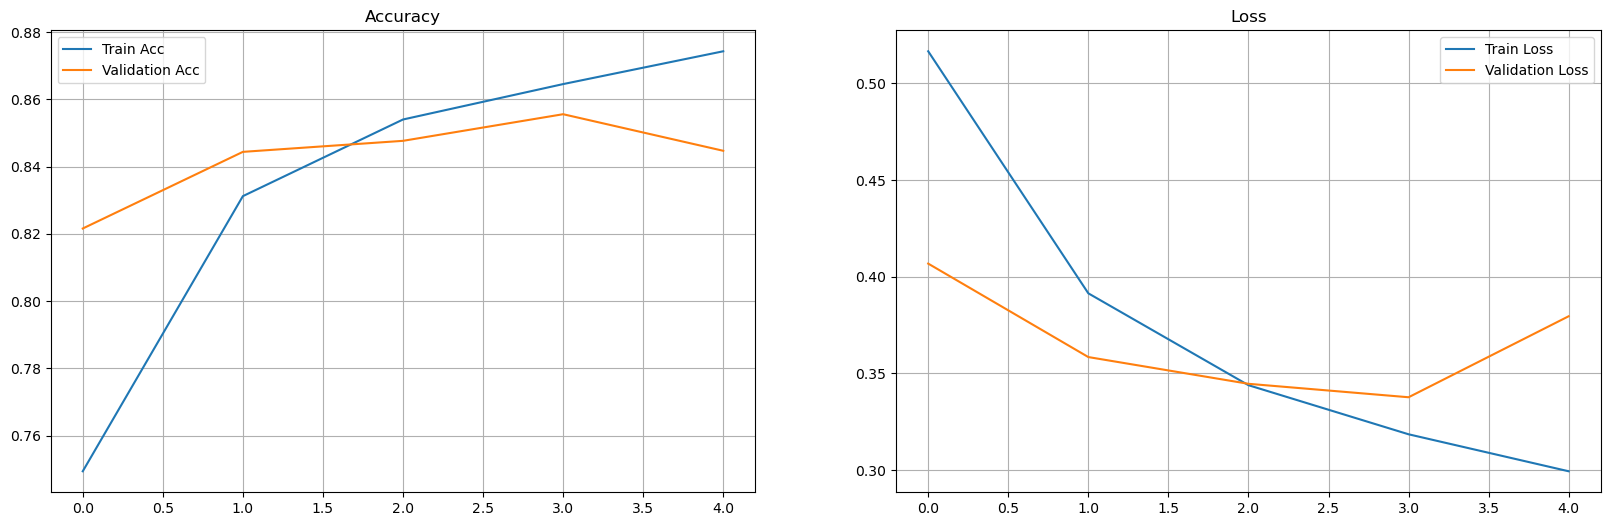

In [20]:
# Create a figure with a specified size (20 inches by 6 inches)
fig = plt.figure(figsize=(20, 6))

# Create the first subplot for accuracy
plt.subplot(1, 2, 1)
plt.plot(epoch_tr_acc, label='Train Acc')  # Plot training accuracy
plt.plot(epoch_vl_acc, label='Validation Acc')  # Plot validation accuracy
plt.title("Accuracy")  # Set the title for the accuracy subplot
plt.legend()  # Display the legend
plt.grid()  # Display a grid for better readability

# Create the second subplot for loss
plt.subplot(1, 2, 2)
plt.plot(epoch_tr_loss, label='Train Loss')  # Plot training loss
plt.plot(epoch_vl_loss, label='Validation Loss')  # Plot validation loss
plt.title("Loss")  # Set the title for the loss subplot
plt.legend()  # Display the legend
plt.grid()  # Display a grid for better readability

# Display the figure
plt.show()

In [21]:
def predict_text(text):
    # Convert each word in the input text to its corresponding index in the vocabulary
    word_seq = np.array([vocab[preprocess_string(word)] for word in text.split()
                         if preprocess_string(word) in vocab.keys()])
    
    # Add an extra dimension to make it a batch of size 1
    word_seq = np.expand_dims(word_seq, axis=0)
    
    # Pad the sequence to ensure it has a consistent length (in this case, 500)
    pad = torch.from_numpy(padding_(word_seq, 500))
    
    # Move the padded sequence to the appropriate device (GPU or CPU)
    inputs = pad.to(device)
    
    # Initialize the hidden state for the model with batch size 1
    batch_size = 1
    h = model.init_hidden(batch_size)
    
    # Ensure the hidden state is detached from the computational graph and converted to tensors
    h = tuple([each.data for each in h])
    
    # Forward pass through the model to get the output
    output, h = model(inputs, h)
    
    # Return the predicted output (as a single float value)
    return output.item()


In [22]:
index = 30  # Index of the review to predict

# Print the review text from the DataFrame at the specified index
print(df['review'][index])
print('='*70)

# Print the actual sentiment label from the DataFrame at the specified index
print(f'Actual sentiment is  : {df["sentiment"][index]}')
print('='*70)

# Use the predict_text function to predict the sentiment of the review
pro = predict_text(df['review'][index])

# Determine if the predicted sentiment is positive or negative based on the predicted probability
status = "positive" if pro > 0.5 else "negative"

# Adjust the probability to be 1 - pro if the sentiment is predicted as negative
pro = (1 - pro) if status == "negative" else pro

# Print the predicted sentiment and its associated probability
print(f'Predicted sentiment is {status} with a probability of {pro}')


Taut and organically gripping, Edward Dmytryk's Crossfire is a distinctive suspense thriller, an unlikely "message" movie using the look and devices of the noir cycle.<br /><br />Bivouacked in Washington, DC, a company of soldiers cope with their restlessness by hanging out in bars. Three of them end up at a stranger's apartment where Robert Ryan, drunk and belligerent, beats their host (Sam Levene) to death because he happens to be Jewish. Police detective Robert Young investigates with the help of Robert Mitchum, who's assigned to Ryan's outfit. Suspicion falls on the second of the three (George Cooper), who has vanished. Ryan slays the third buddy (Steve Brodie) to insure his silence before Young closes in.<br /><br />Abetted by a superior script by John Paxton, Dmytryk draws precise performances from his three starring Bobs. Ryan, naturally, does his prototypical Angry White Male (and to the hilt), while Mitchum underplays with his characteristic alert nonchalance (his role, howeve

In [23]:
index = 100  # Index of the review to predict

# Print the review text from the DataFrame at the specified index
print(df['review'][index])
print('='*70)

# Print the actual sentiment label from the DataFrame at the specified index
print(f'Actual sentiment is  : {df["sentiment"][index]}')
print('='*70)

# Use the predict_text function to predict the sentiment of the review
pro = predict_text(df['review'][index])

# Determine if the predicted sentiment is positive or negative based on the predicted probability
status = "positive" if pro > 0.5 else "negative"

# Adjust the probability to be 1 - pro if the sentiment is predicted as negative
pro = (1 - pro) if status == "negative" else pro

# Print the predicted sentiment and its associated probability
print(f'Predicted sentiment is {status} with a probability of {pro}')


This short film that inspired the soon-to-be full length feature - Spatula Madness - is a hilarious piece that contends against similar cartoons yielding multiple writers. The short film stars Edward the Spatula who after being fired from his job, joins in the fight against the evil spoons. This premise allows for some funny content near the beginning, but is barely present for the remainder of the feature. This film's 15-minute running time is absorbed by some odd-ball comedy and a small musical number. Unfortunately not much else lies below it. The plot that is set up doesn't really have time to show. But it's surely follows it plot better than many high-budget Hollywood films. This film is worth watching at least a few times. Take it for what it is, and don't expect a deep story.
Actual sentiment is  : positive
Predicted sentiment is negative with a probability of 0.6808410882949829
